In [1]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd

# setup environment
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.compat.v1.enable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append(os.getcwd() + "/../")

import bfcnn

In [2]:
# base directory for test images
IMAGES_TEST_DIR = \
    pathlib.Path(os.path.abspath("")).parent.resolve() / "images" / "test"

# directory of kitti test images
KITTI_DIR = \
    IMAGES_TEST_DIR / "kitti"

# all the kitti test images
KITTI_IMAGES = \
    [img for img in (KITTI_DIR / "files").glob("*.png")]


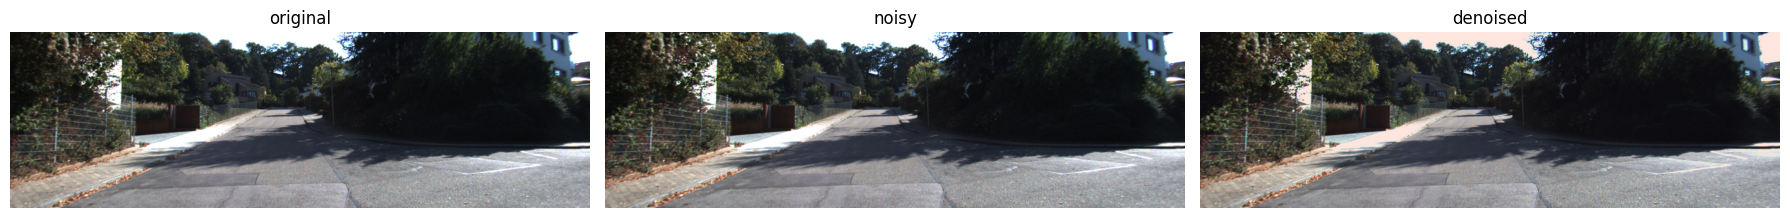

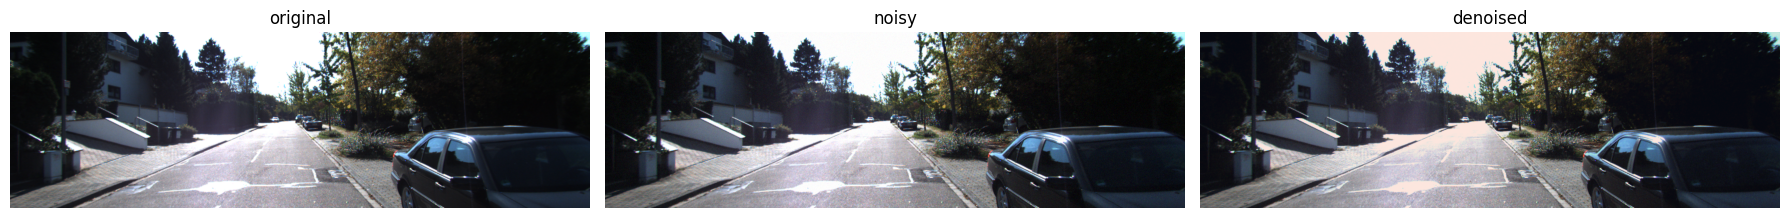

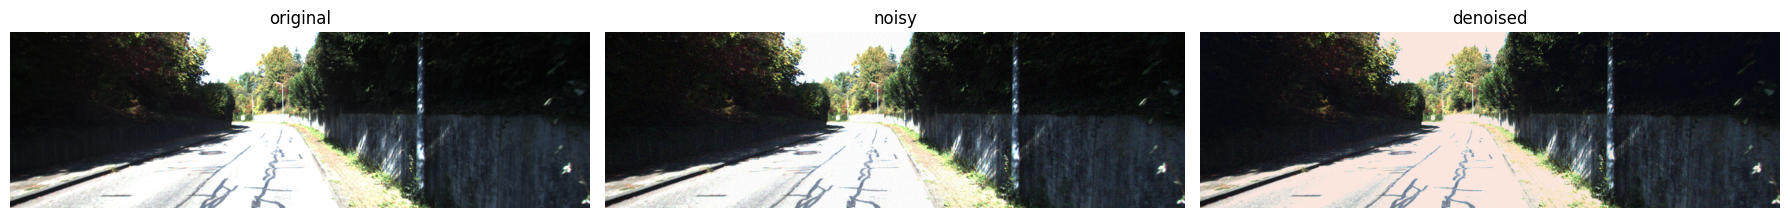

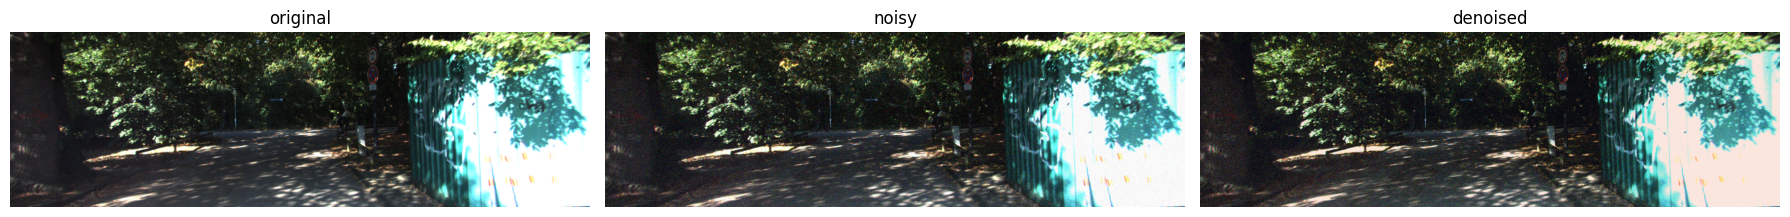

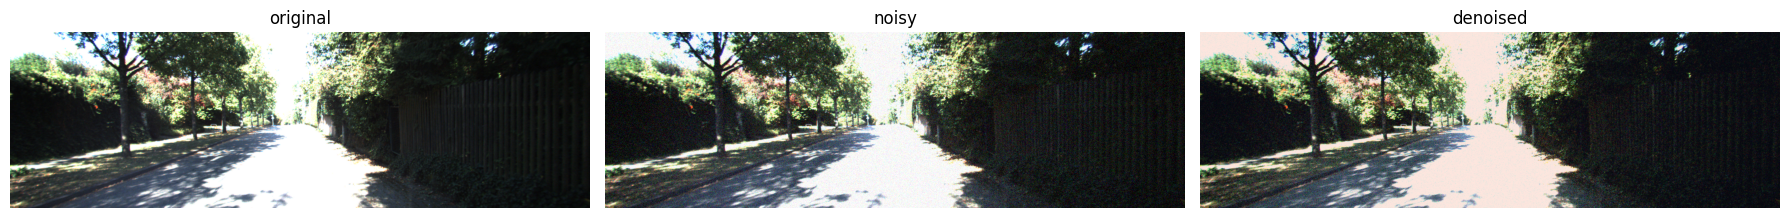

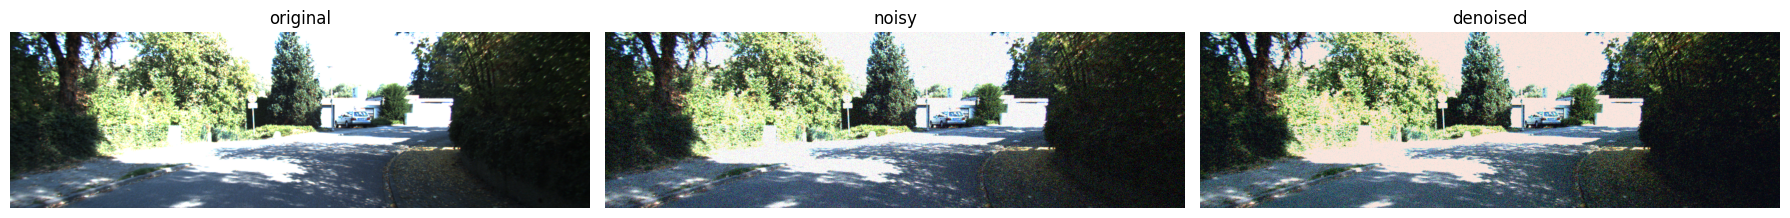

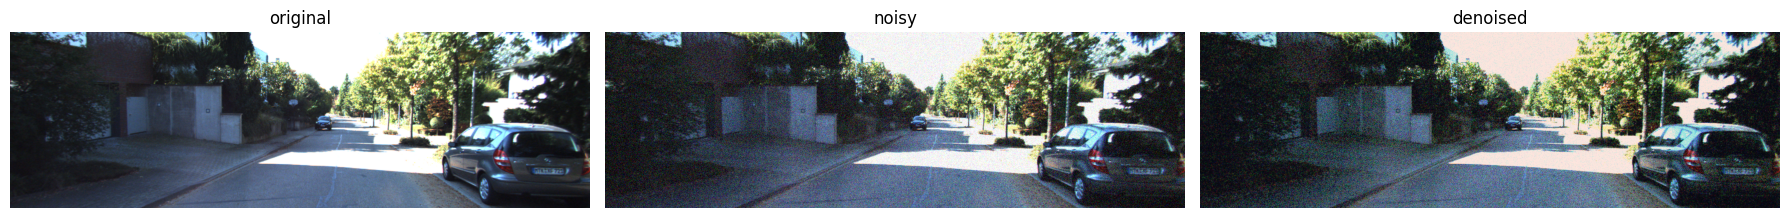

In [ ]:
SHOW_IMAGES = True
NO_CHANNELS = 3
FIG_SIZE = (18, 6)
CROP_SIZE = (256, 256)
VISUALIZE_FIG_SIZE = (20,12)
NOISE_STD = list(range(0, 100, 5))
RESOLUTIONS= [(256,768)]
MODEL = "resnet_color_1x6_bn_32x32_1x3x1_128x128_erf_relu"
KITTI_IMAGES_SAMPLE = KITTI_IMAGES

denoiser_module = bfcnn.load_denoiser_model(MODEL)
img_path = KITTI_IMAGES_SAMPLE[2]
resolution = (256, 768)
model_name = MODEL

df = \
    pd.DataFrame(
        columns=[
            "noise_std",
            "mae noisy",
            "mae denoised",
            "rmse denoised",
        ])


for index, noise_std in enumerate(NOISE_STD):
    # --- pick image
    img_path = KITTI_IMAGES_SAMPLE[index % len(KITTI_IMAGES_SAMPLE)]
    img_original = \
        bfcnn.load_image(
            path=img_path, 
            num_channels=3, 
            dtype=tf.uint8,
            image_size=None, 
            expand_dims=True, 
            normalize=False)
    
    img_noisy = \
        tf.cast(img_original, dtype=tf.float32) + \
        tf.random.truncated_normal(
            mean=0,
            stddev=noise_std,
            dtype=tf.float32,
            shape=img_original.shape)
    
    img_noisy = \
        tf.cast(
            tf.clip_by_value(
                img_noisy, 
                clip_value_min=0.0, 
                clip_value_max=255.0), 
        dtype=tf.uint8)
    
    # ---
    img_denoised = denoiser_module(img_noisy)
    
    # ---
    img_original_np = img_original.numpy()
    img_noisy_np = img_noisy.numpy()
    img_denoised_np = img_denoised.numpy()
    
    # --- calculate mae, mse
    mae_noisy = \
        np.mean\
            (np.abs(img_original_np.astype("float") - img_noisy_np.astype("float")),
             axis=None)
    mae_denoised = \
        np.mean\
            (np.abs(img_original_np.astype("float") - img_denoised_np.astype("float")),
             axis=None)
    rmse_denoised = \
        np.sqrt(np.mean\
            (np.square(img_original_np.astype("float") - img_denoised_np.astype("float")),
             axis=None))
    # --- append df

    df = \
        pd.concat([
            df,
            pd.DataFrame({
                "noise_std": f"{noise_std}",
                "mae noisy": f"{mae_noisy:0.2f}",
                "mae denoised": f"{mae_denoised:0.2f}",
                "rmse denoised": f"{rmse_denoised:0.2f}",
            }, index=[0])],
        ignore_index=True)

    # --- visualize or not
    if SHOW_IMAGES:
        norm = plt.Normalize(0, 255)
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=FIG_SIZE)
        im0 = axes[0].imshow(img_original_np[0,:,:,:], norm=norm)
        im1 = axes[1].imshow(img_noisy_np[0,:,:,:], norm=norm)
        im2 = axes[2].imshow(img_denoised_np[0,:,:,:], norm=norm)
        axes[0].set_title(f"original")
        axes[0].axis("off")
        axes[1].set_title(f"noisy")
        axes[1].axis("off")
        axes[2].set_title(f"denoised")
        axes[2].axis("off")
        plt.tight_layout()
        plt.show()

In [ ]:
display(df)
